## References
* [Kaggle, Coronavirus (COVID-19) Visualization & Prediction](https://www.kaggle.com/code/therealcyberlord/coronavirus-covid-19-visualization-prediction/notebook#US-Medical-Data-on-Testing)  </br>

* [Kaggle, COVID-19 - Analysis, Visualization & Comparisons](https://www.kaggle.com/code/imdevskp/covid-19-analysis-visualization-comparisons#Date-vs) </br>
* [Worldmeters Coronavirus](https://www.worldometers.info/coronavirus/#countries) </br>
* [Johns Hopkins Center for Systems Science and Engineering COVID-19 GitHub](https://github.com/CSSEGISandData/COVID-19) </br>
* [Johns Hopkins Coronavirus Resouce Center](https://coronavirus.jhu.edu/map.html) </br> 
* [World Population](https://worldpopulationreview.com/countries)</br>

# Libraries 

In [715]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import pandas as pd
import random 
import math 
import time 
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import datetime
import operator 
plt.style.use('seaborn-poster')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings 
warnings.filterwarnings('ignore')

# interactive visualization
import plotly.express as px
import plotly.graph_objs as go
# import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Data

Update flow:
1. Update parameter:
  a. Change country 
  b. Check date from imported data 
  c. Modify the update date parameter 
2. Run main script 
3. Run load script 
4. Copy, add, commit, and push 
5. Reload load fig script for latest update

In [716]:
# countries = ['US']
countries = ['Taiwan*', 'US', 'Hong Kong', 'Vietnam', 'Singapore', 'India', 'New Zealand', ]
update = '04/05/2022'
# offset from 01/22/2022
offsetDays = 0


Import Data

In [717]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
population_df = pd.read_csv('population.csv')

In [718]:
recoveries_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/22,3/28/22,3/29/22,3/30/22,3/31/22,4/1/22,4/2/22,4/3/22,4/4/22,4/5/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [719]:
population_df

,Rank,name,pop2022,pop2021,GrowthRate,area,Density
0,203,Monaco,39.783,39.511,1.0069,2,19891.5000
1,115,Singapore,5943.546,5896.686,1.0079,710,8371.1915
2,105,Hong Kong,7604.299,7552.810,1.0068,1104,6887.9520
3,156,Bahrain,1783.983,1748.296,1.0204,765,2332.0039
4,176,Maldives,540.985,543.617,0.9952,300,1803.2833
...,...,...,...,...,...,...,...
204,183,Iceland,345.393,343.353,1.0059,103000,3.3533
205,146,Namibia,2633.874,2587.344,1.0180,825615,3.1902
206,173,Western Sahara,626.161,611.875,1.0233,266000,2.3540
207,137,Mongolia,3378.078,3329.289,1.0147,1564110,2.1597


Process Data

In [720]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i] - data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i < window_size:
            moving_average.append(np.mean(data[ : i]))
        else:
            moving_average.append(np.mean(data[i - window_size : i]))
    return moving_average 

window = 7


In [721]:
# ideally should be able to set start date and end date

# Get dates 
cols = confirmed_df.keys()
date = np.array(cols)[4:-1]

for country in countries: 
    # get population 
    population = population_df[population_df['name']==country]['pop2022']
    population = int(population)/1e3
    print( population )

    
    # Search from 'Country/Region' or 'Province/State'
    searchFrom = 'Country/Region'
    aRow = confirmed_df[confirmed_df[searchFrom]==country]
    if aRow.shape[0] == 0:
        searchFrom = 'Province/State'

    # Get data
    totalConfirmedRows = confirmed_df[confirmed_df[searchFrom]==country]
    totalDeathsRows = deaths_df[deaths_df[searchFrom]==country]

    totalConfirmed = []
    totalDeaths = []
    # skip the first 4 columns. they are state, country, lat, and long 
    for i in range(4, len(date)+4):
        ConfirmedVal = sum(np.array(totalConfirmedRows)[:,i])
        DeathVal = sum(np.array(totalDeathsRows)[:,i])
        totalConfirmed.append(ConfirmedVal)
        totalDeaths.append(DeathVal)

    totalMortality = []
    for i in range(len(totalConfirmed)):
        if totalConfirmed[i] == 0:
            totalMortality.append(0)
        else: 
            totalMortality.append(totalDeaths[i]/totalConfirmed[i])

    # Create DataFrame 
    new_df = pd.DataFrame( 
            {   'Date': date[offsetDays:-1], 
                'Total Confirmed': moving_average(totalConfirmed, window)[offsetDays:-1], 
                'Daily Confirmed': moving_average(daily_increase(totalConfirmed), window)[offsetDays:-1], 
                'Total Confirmed Per 1M Population' : np.array(moving_average(totalConfirmed, window)[offsetDays:-1])/population, 
                'Total Deaths': moving_average(totalDeaths, window)[offsetDays:-1],
                'Daily Deaths': moving_average(daily_increase(totalDeaths), window)[offsetDays:-1], 
                'Total Deaths Per 1M Population' : np.array(moving_average(totalDeaths, window)[offsetDays:-1])/population, 
                'Total Mortality': moving_average(totalMortality, window)[offsetDays:-1],
                # 'Daily Mortality': daily_increase(totalMortality), 
            } 
        )


    # Save DataFrame 
    country = country.split('*')
    country = ''.join(country)
    new_df.to_csv(country+'.csv')

    print('Processing: {}'.format(country))
    # print(new_df.tail())




23.888
Processing: Taiwan
334.805
Processing: US
7.604
Processing: Hong Kong
98.953
Processing: Vietnam
5.943
Processing: Singapore
1406.631
Processing: India
4.898
Processing: New Zealand


# Visualization

In [722]:
def ploty_line(col, log_plot=False):
    df2 = pd.DataFrame()
    for country in countries:
        # read data 
        country = country.split('*')
        country = ''.join(country)
        df = pd.read_csv(country+'.csv')
        # add another column 
        df['Country'] = [country for _ in range(df['Date'].shape[0])]
        df2 = df2.append(df, ignore_index=True)


    df2.rename(columns = {'Country': update}, inplace = True)
    fig = px.scatter(
        df2, x='Date', y=col, color= update,
        height=550, width=800, title=col, log_y=log_plot, 
        # color_discrete_sequence = px.colors.cyclical.mygbm 
    )
    fig.update_layout(showlegend=True)     
    fig.show()
    # fig.write_image("fig.png")
    # fig.to_image(format="png", engine="orca")


In [723]:
ploty_line('Total Confirmed', log_plot=True)

In [724]:
# ,Date,Total Confirmed,Daily Confirmed,Total Deaths,Daily Deaths,Total Mortality
ploty_line('Daily Confirmed', log_plot=True)

In [725]:
ploty_line('Total Confirmed Per 1M Population', log_plot=True)

In [726]:
ploty_line('Total Deaths', log_plot=True)

In [727]:
ploty_line('Daily Deaths', log_plot=True)

In [728]:
ploty_line('Total Mortality', log_plot=True)


In [729]:
ploty_line('Total Deaths Per 1M Population', log_plot=True)

# Static image and save image 

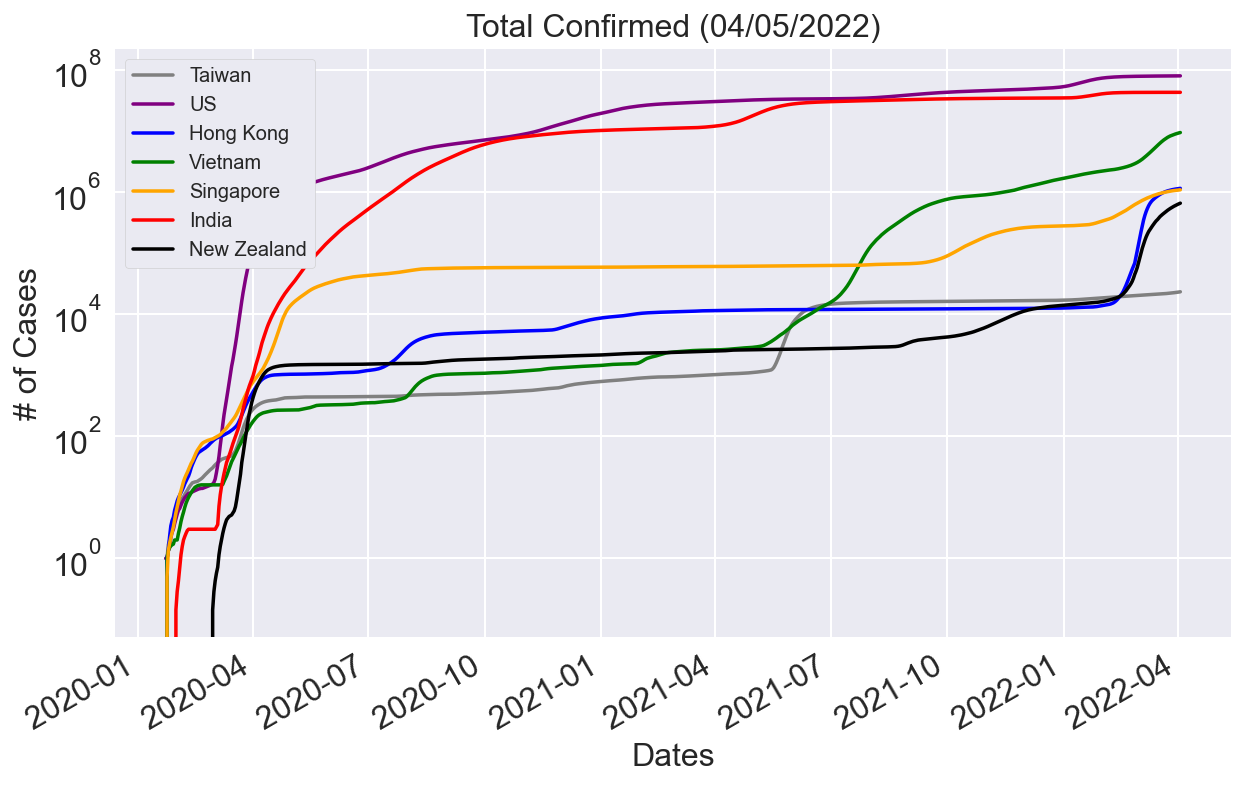

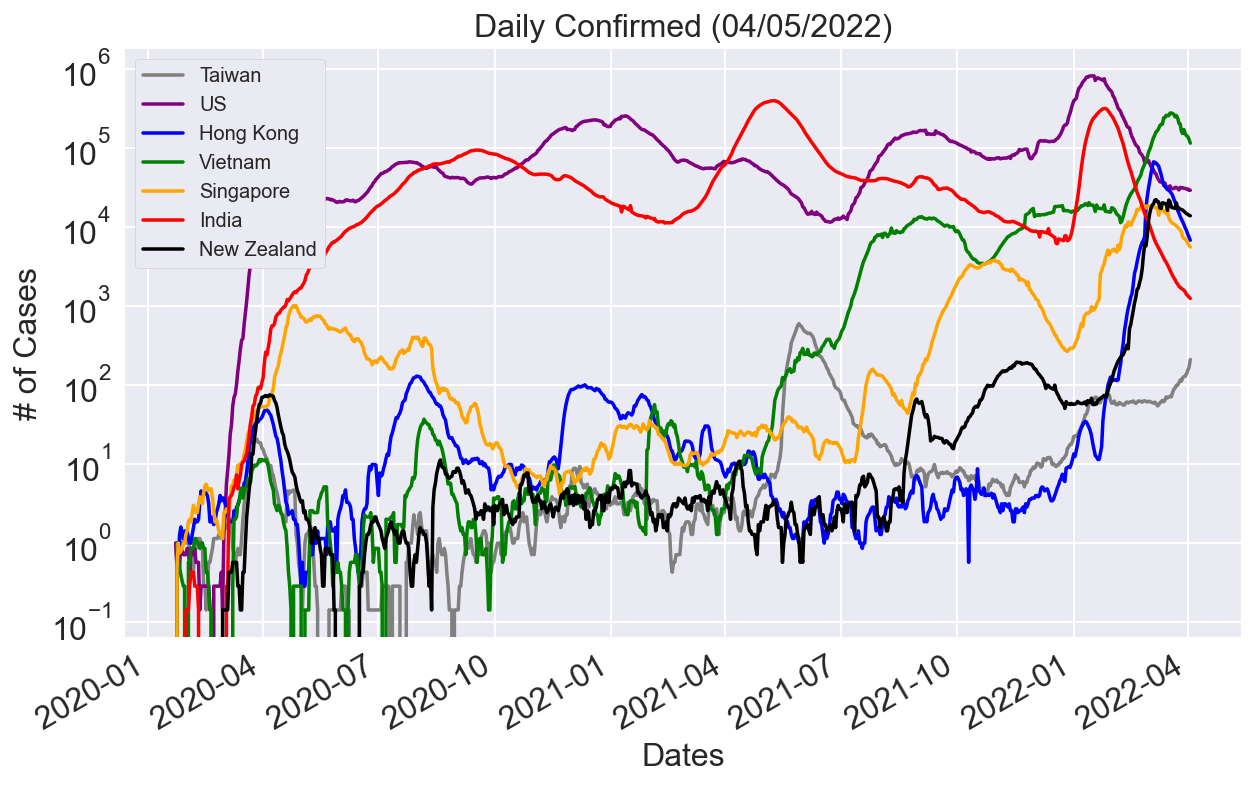

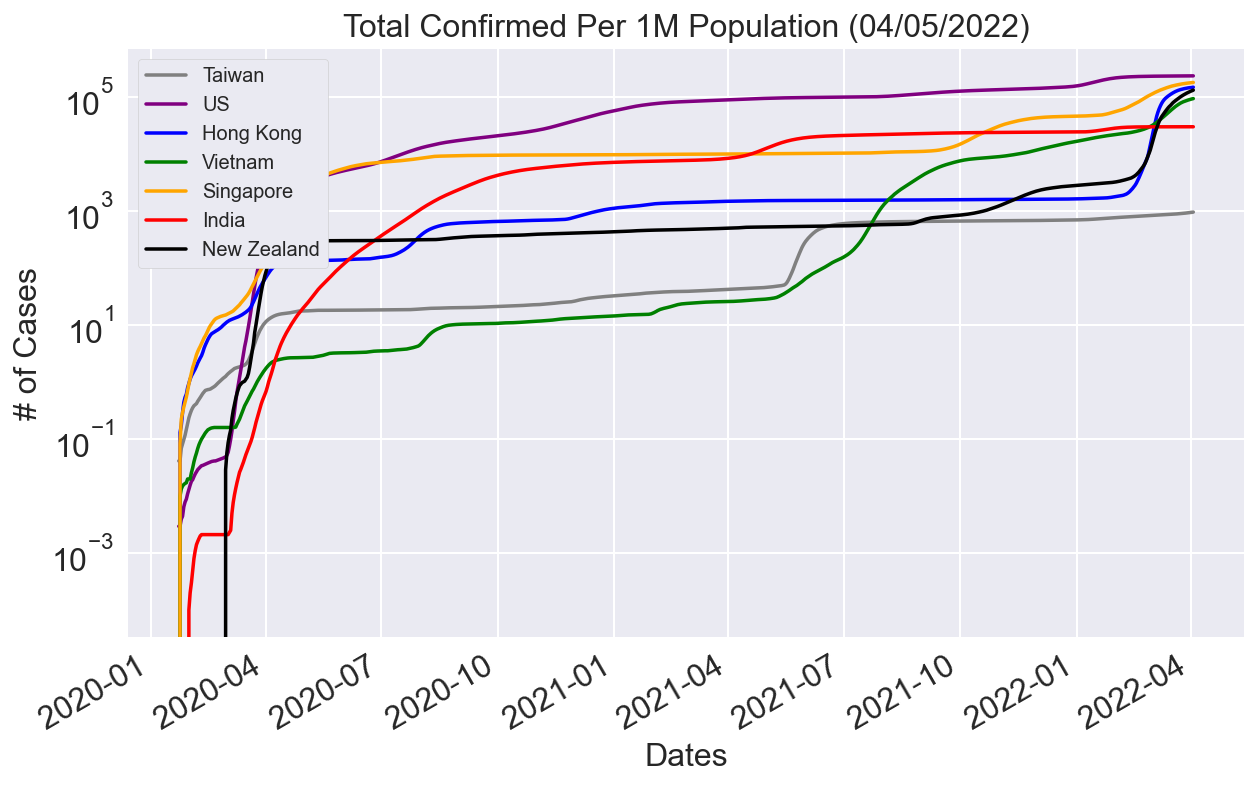

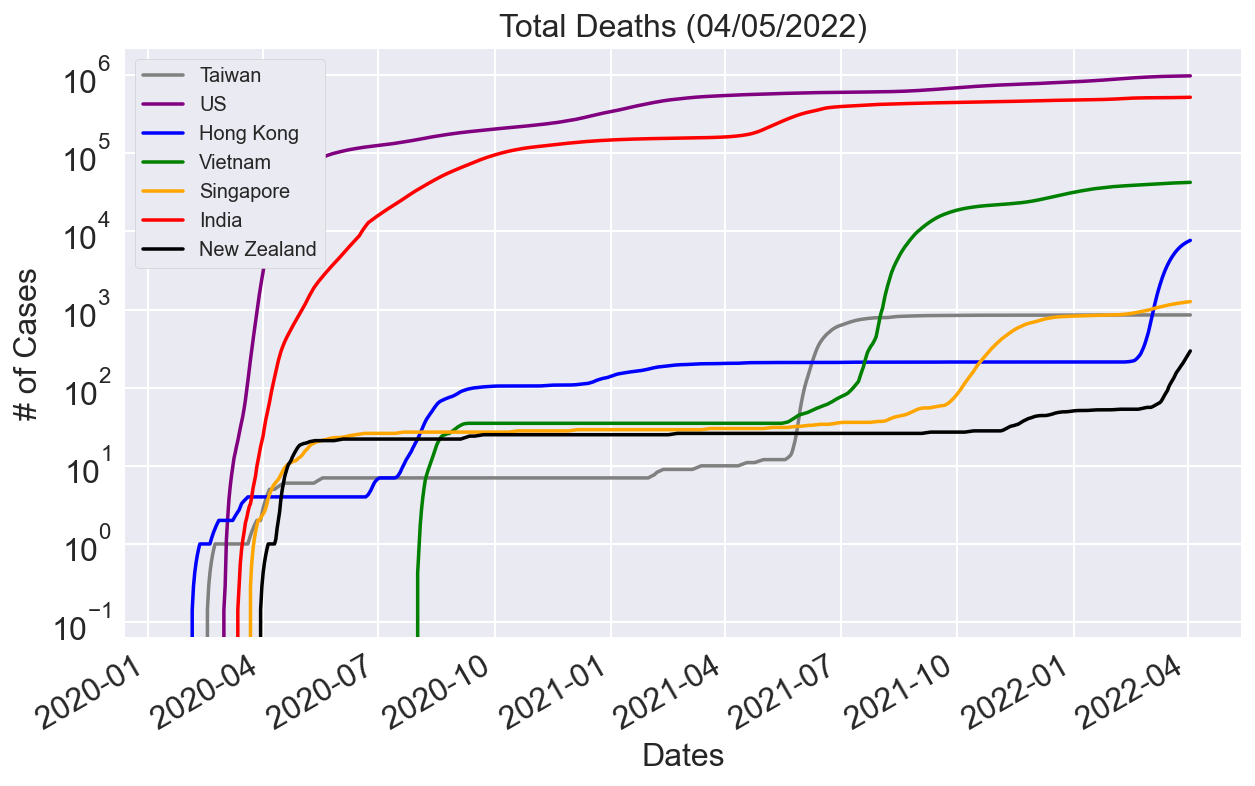

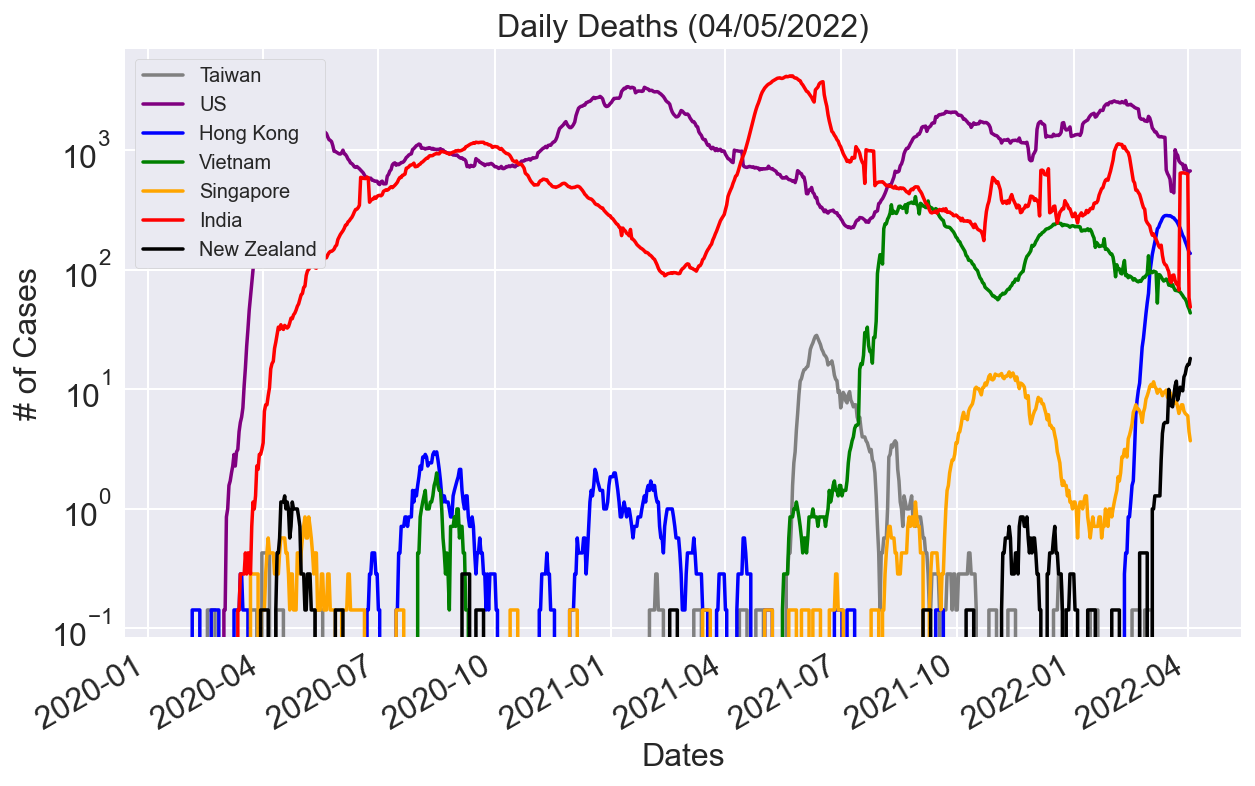

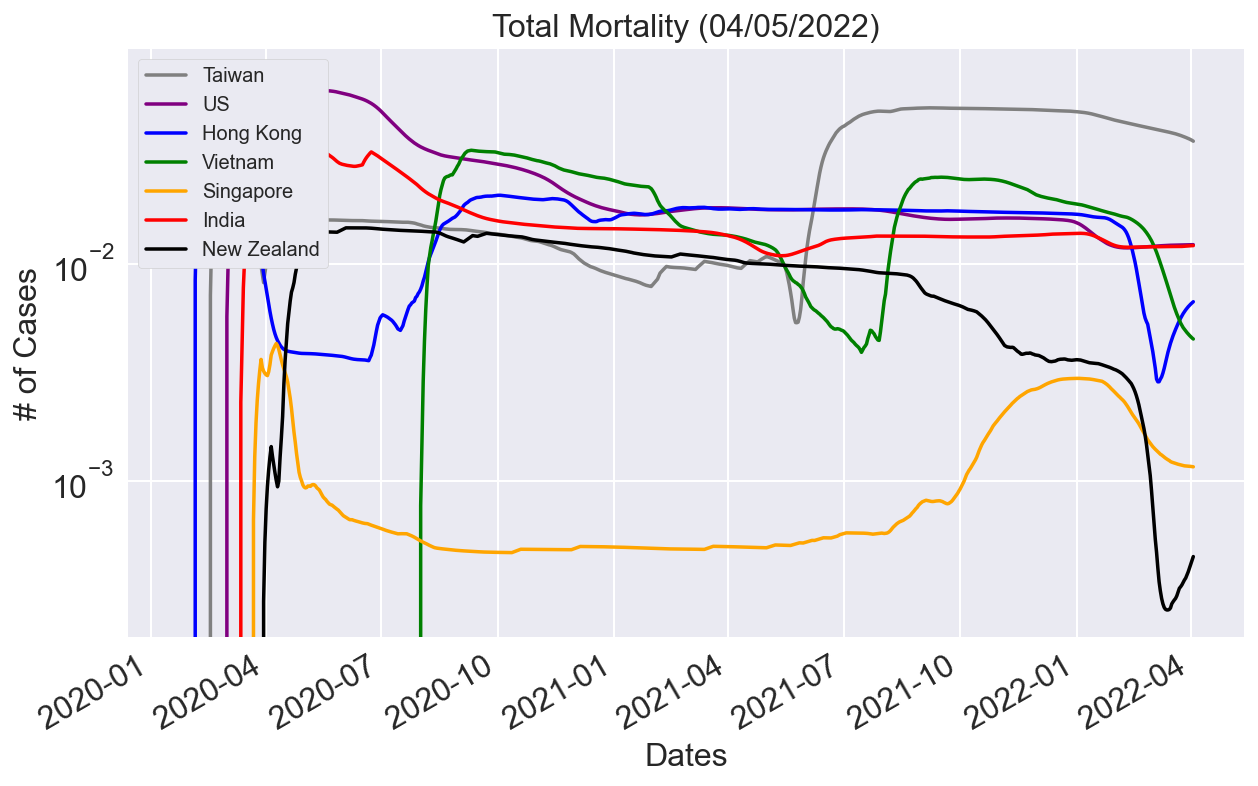

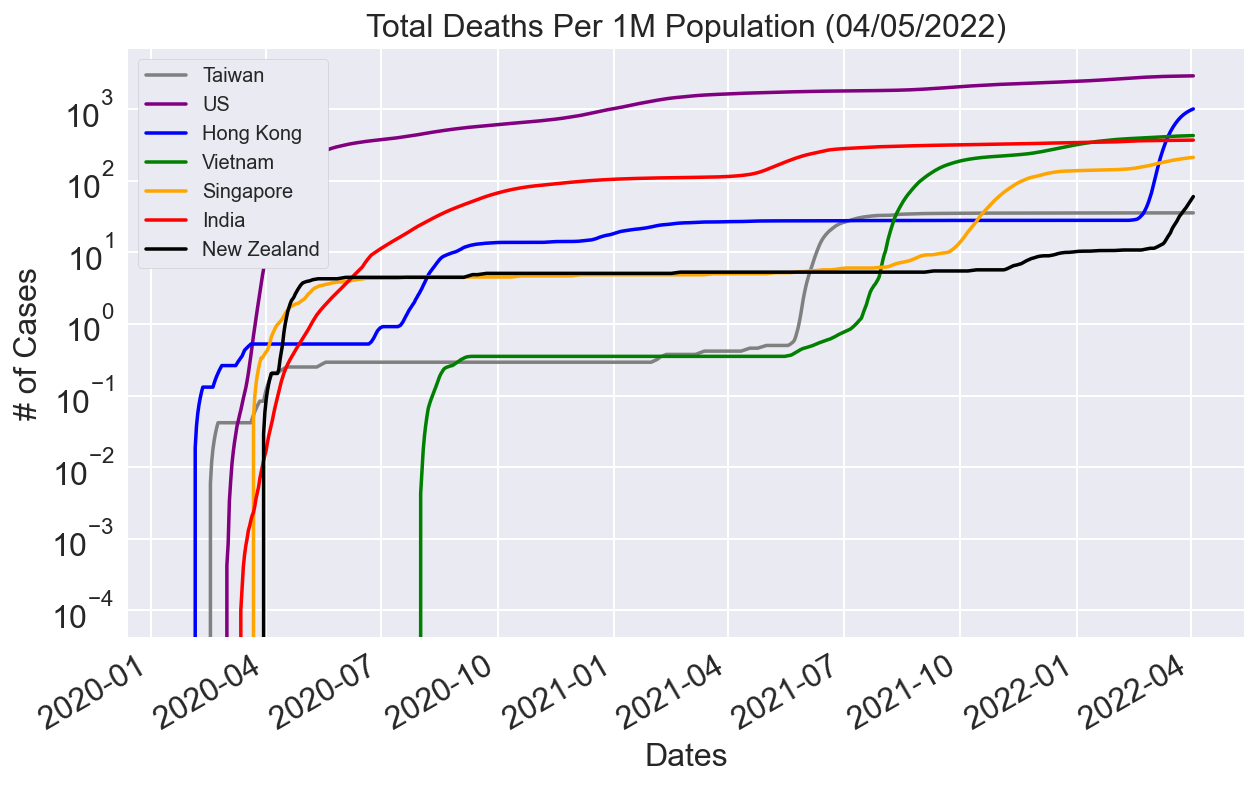

In [735]:
def plot_line(col):
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn')
    cmap = ['Grey', 'Purple', 'Blue', 'Green', 'Orange', 'Red',
            'black', 'magneta', 'navy', 'darkgreen', 'darkorange', 'darkRed'
            ]
    for i, country in enumerate(countries):
        # read data 
        country = country.split('*')
        country = ''.join(country)
        df = pd.read_csv(country+'.csv')


        # Convert string to datetime for pandas to recognise 
        df['Date'] = pd.to_datetime(df['Date'])

        plt.plot(df['Date'], df[col], color=cmap[i], linestyle='solid', label=country)

    plt.yscale("log")
    plt.gcf().autofmt_xdate()
    plt.title(col + ' (' + update + ')', size = 16)
    # plt.legend([country], prop={'size' : 16})
    # plt.legend(prop={'size' : 16, 'loc': 'best'})
    plt.legend(loc='upper left', frameon=True, framealpha=True, prop={'size' : 10})
    # plt.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1, prop={'size' : 16})
    plt.xlabel('Dates', size=16)
    plt.ylabel('# of Cases', size=16)
    plt.xticks(size=16)
    plt.yticks(size=16)

    plt.savefig(col+'.png')

plot_line('Total Confirmed')
plot_line('Daily Confirmed')
plot_line('Total Confirmed Per 1M Population')
plot_line('Total Deaths')
plot_line('Daily Deaths')
plot_line('Total Mortality')
plot_line('Total Deaths Per 1M Population')



# [Matplotlib Tutorial (Part 10): Subplots](https://www.youtube.com/watch?v=XFZRVnP-MTU&list=PL-osiE80TeTvipOqomVEeZ1HRrcEvtZB_&index=10)

import data

In [736]:
country = 'Taiwan'
df = pd.read_csv(country+'.csv')
df



,Unnamed: 0,Date,Total Confirmed,Daily Confirmed,Total Confirmed Per 1M Population,Total Deaths,Daily Deaths,Total Deaths Per 1M Population,Total Mortality
0,0,1/22/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1/23/20,1.000000,1.000000,0.041862,0.0,0.0,0.000000,0.000000
2,2,1/24/20,1.000000,0.500000,0.041862,0.0,0.0,0.000000,0.000000
3,3,1/25/20,1.666667,1.000000,0.069770,0.0,0.0,0.000000,0.000000
4,4,1/26/20,2.000000,0.750000,0.083724,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
798,798,3/30/22,22600.142857,128.714286,946.087695,853.0,0.0,35.708305,0.037749
799,799,3/31/22,22738.285714,138.142857,951.870634,853.0,0.0,35.708305,0.037519
800,800,4/1/22,22890.714286,152.428571,958.251603,853.0,0.0,35.708305,0.037270
801,801,4/2/22,23057.285714,166.571429,965.224620,853.0,0.0,35.708305,0.037003


Use matplotlib.pyplot

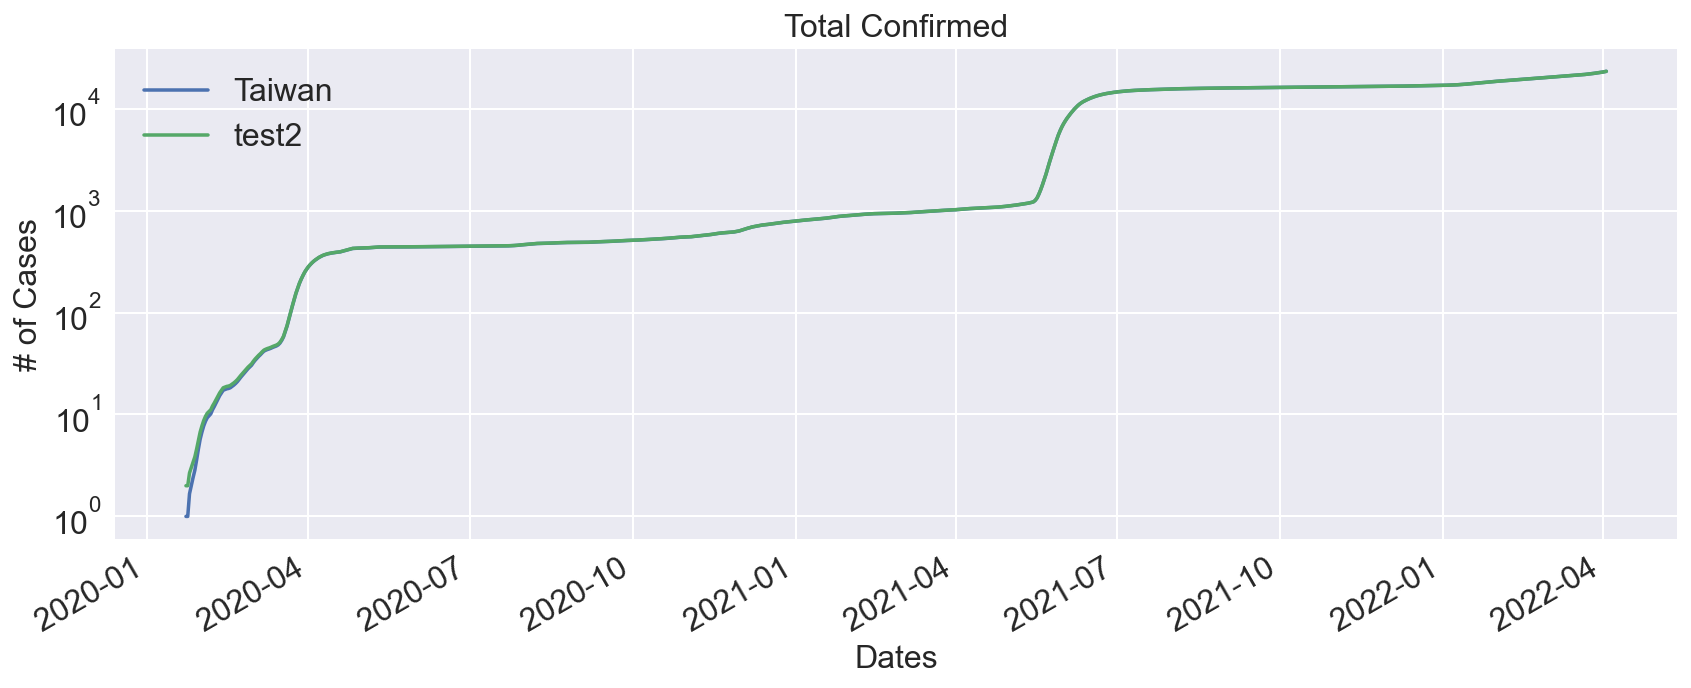

In [737]:
col = 'Total Confirmed'

plt.figure(figsize=(14, 5))
plt.style.use('seaborn')
# Convert string to datetime for pandas to recognise 
df['Date'] = pd.to_datetime(df['Date'])

plt.plot(df['Date'], df[col], linestyle='solid', label=country)
plt.plot(df['Date'], np.array(df[col])+1, linestyle='solid', label='test2')
plt.yscale("log")

plt.gcf().autofmt_xdate()
plt.title(col, size = 16)
# plt.legend([country], prop={'size' : 16})
plt.legend(prop={'size' : 16})
plt.xlabel('Dates', size=16)
plt.ylabel('# of Cases', size=16)
plt.xticks(size=16)
plt.yticks(size=16)

plt.savefig('fig.png')


Use fig, ax, from subplots

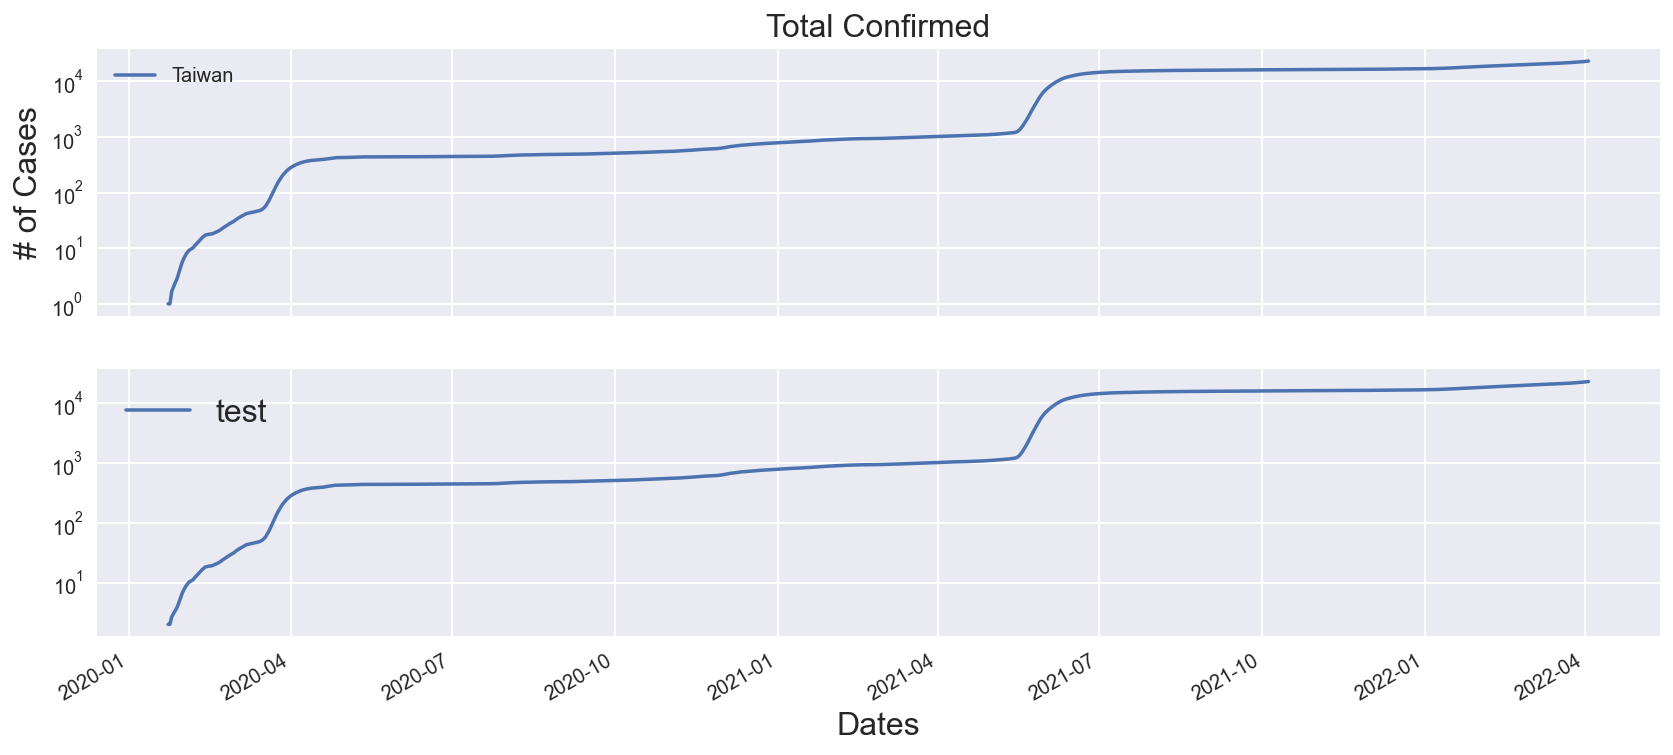

In [738]:
col = 'Total Confirmed'
# Convert string to datetime for pandas to recognise 
df['Date'] = pd.to_datetime(df['Date'])
#
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=2, ncols=1)

#
ax[0].plot(df['Date'], df[col], linestyle='solid', label=country)
ax[0].set_yscale("log")
ax[0].set_title(col, size = 16)
ax[0].legend()
ax[0].set_ylabel('# of Cases', size=16)
#
ax[1].plot(df['Date'], np.array(df[col])+1, linestyle='solid', label='test')
ax[1].set_yscale("log")
ax[1].legend(prop={'size' : 16})
ax[1].set_xlabel('Dates', size=16)
#

# Will have multiple ax. But still only one fig 
fig.set_size_inches(14, 6)
fig.autofmt_xdate()
fig.savefig('TestAxFig.png')

# not easy to use 
#ax[0].minorticks_on()
# ax[1].set_yticks(size=16)



Modifing the xticks 

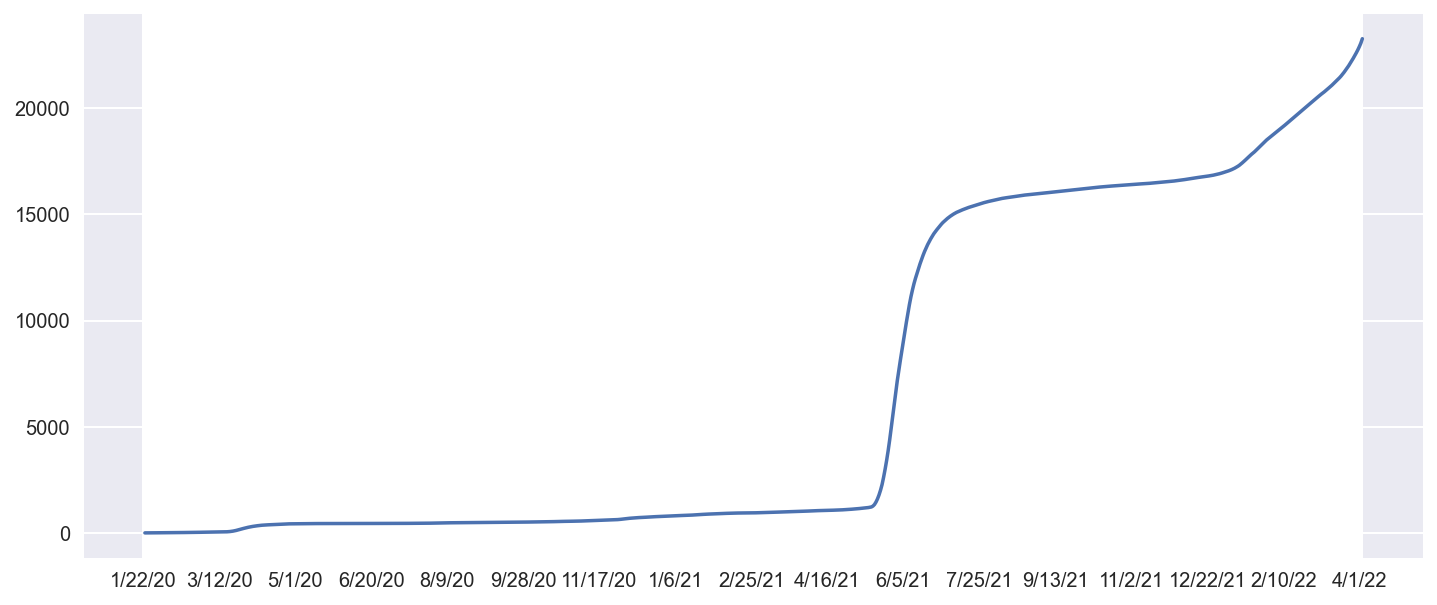

In [739]:
country = 'Taiwan'
df = pd.read_csv(country+'.csv')

fig, ax = plt.subplots()

# plt.figure(figsize=(16, 4))
# plt.locator_params(axis='x', nbins=6)
# plt.locator_params(axis='y', nbins=10)
ax.plot(df['Date'], df['Total Confirmed'])
ax.axes.grid(True)
fig.set_size_inches(12, 5)

every_nth = 50
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

